# Notebook for model training analysis

Imports

In [2]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from Modules import utils, plot_utils

Useful global variables

In [3]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Plot test distribution

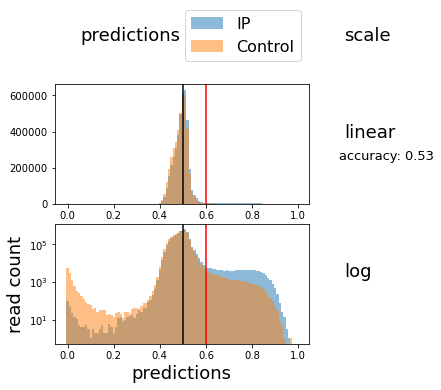

In [106]:
data = 'Judith-H3K4me3'
dataset_name = 'sharded_dataset2'
model_name = 'model_inception3.1'
load_hist = False
hist_file = f'distrib_{model_name}_test_hist100000'
relabeled = False
new_labels = 'dataset_rel8'
single_pred_array = True
sharded = True
if load_hist:
    with np.load(f'{writing_dir}/{data}/results/{model_name}/{hist_file}.npz') as f:
        histIP = f['IP']
        histControl = f['Control']
    bins = np.linspace(0, 1, len(histIP)+1)
    win_start = 80000
    win_stop = 80100
    histIP, histControl, bins = histIP[win_start:win_stop], histControl[win_start:win_stop], bins[win_start:win_stop+1]
else:
    if single_pred_array:
        if relabeled:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            with np.load(f'{data_dir}//{data}/{new_labels}.npz') as f:
                y_test = f['y_test']
        else:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            if sharded:
                y_test = np.zeros(len(preds), dtype=bool)
                y_test[::2] = 1
            else:
                with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
                    y_test = f['y_test']
        predIP = preds[y_test == 1]
        predControl = preds[y_test == 0]
    else:
        with np.load(f'{data_dir}/{data}/results/distrib_{model_name}_test.npz') as f:
                predIP = f['predIP']
                predControl = f['predControl']
    accuracy = (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
    n_bins = 100
    histIP, bins = np.histogram(predIP, bins=n_bins, range=(0, 1))
    histControl = np.histogram(predControl, bins=n_bins, range=(0, 1))[0]

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])

    ax0.bar(bins[:-1], histIP, width=np.diff(bins), label='IP', alpha=0.5)
    ax0.bar(bins[:-1], histControl, width=np.diff(bins), label='Control', alpha=0.5)

    if not load_hist:
        ax0.axvline(x=0.5, color='black')#, label='t0.5')
        thres = 0.6
        ax0.axvline(x=thres, color='red')#, label=f't{thres}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        if not load_hist:
            ax1.annotate(f'accuracy: {round(accuracy, 2)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right', fontsize=16)

if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}')
fig_start = f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test'
fig_name = fig_start + '.png'
fig_dups = 0
while os.path.exists(fig_name):
    fig_dups += 1
    fig_name = fig_start + f'({fig_dups}).png'
plt.savefig(fig_name, bbox_inches='tight')
if not load_hist:
    np.savez(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_hist{n_bins}', IP=histIP, Control=histControl)
plt.show()
plt.close()

Select sequences

In [107]:
if sharded:
    with np.load(f'{data_dir}/{data}/{dataset_name}/test_0.npz') as f:
        x_test = f['one_hots']
else:
    with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
        x_test = f['x_test']
# thres = 0.6
selected_reads = x_test[preds.ravel() > thres, :, :]
print(f'nb of selected reads with thres {thres}:', len(selected_reads))

nb of selected reads with thres 0.6: 161662


In [ ]:
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
thres0 = 0.83
thres1 = 0.99
preds = preds.ravel()
mask = np.logical_and(preds > thres0, preds < thres1)
selected_reads = x_test[mask, :, :]
print(f'nb of selected reads between {thres0} and {thres1}:', len(selected_reads))

Write into fasta file

In [108]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres}_with_{model_name}.fasta')

In [ ]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres0}_below_{thres1}_with_{model_name}.fasta')

Plot training logs

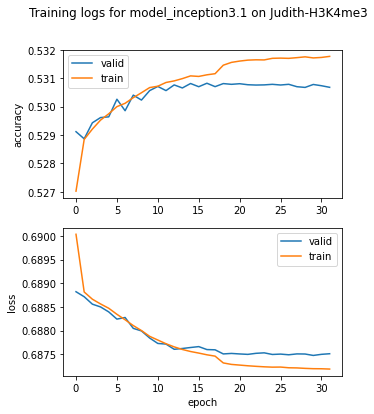

In [109]:
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
logs = pd.read_csv(f'{data_dir}/{data}/Trainedmodels/{model_name}/epoch_data.csv')
fig = plt.figure(figsize=(5, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(211)
ax0.plot(logs['val_accuracy'], label='valid')
ax0.plot(logs['accuracy'], label='train')
ax0.set_ylabel('accuracy')
ax0.legend()

ax1 = plt.subplot(212)
ax1.plot(logs['val_loss'], label='valid')
ax1.plot(logs['loss'], label='train')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
plt.legend()
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/{model_name}_train_log.png', bbox_inches='tight')
plt.show()
plt.close()

In [110]:
IP_accuracy = np.size(predIP[predIP > 0.5]) / np.size(predIP)
Control_accuracy = (np.size(predControl[predControl < 0.5])
                    / np.size(predControl))
print('accuracy: ', (IP_accuracy + Control_accuracy) / 2)
print('IP accuracy: ', IP_accuracy)
print('Control accuracy: ', Control_accuracy)

accuracy:  0.5305672883987427
IP accuracy:  0.5284748077392578
Control accuracy:  0.5326597690582275


Plot test distribution during epochs

29
0.5306406021118164


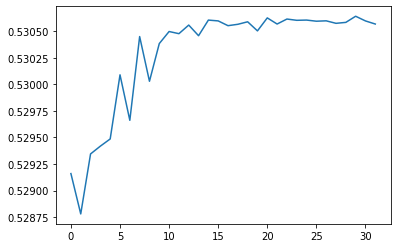

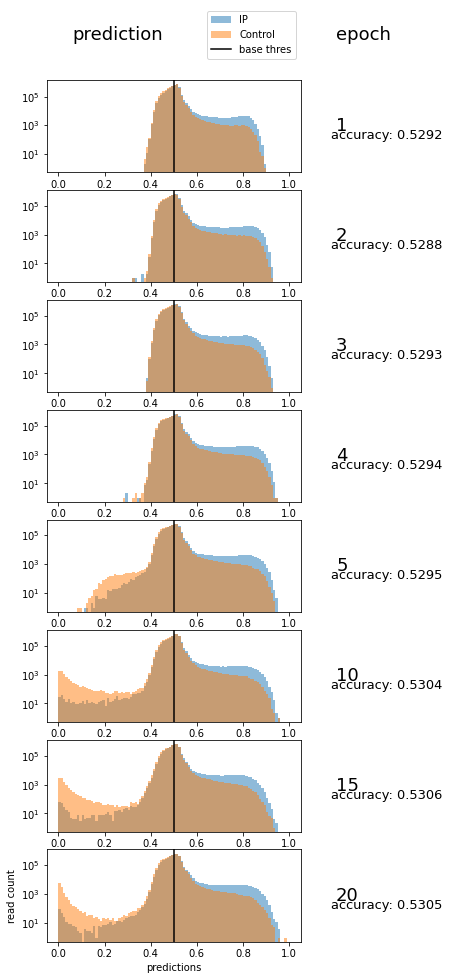

In [4]:
data = 'Judith-H3K4me3'
dataset_name = 'sharded_dataset2'
model_name = 'model_inception3.1'
new_labels = 'dataset_rel8'
relabeled = False
sharded = True
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
# Watching for nan predictions
# for epoch in range(preds.shape[0]):
#     nans = np.count_nonzero(np.isnan(preds[epoch]))
#     print(f'Epoch {epoch}: {nans} nan predictions')
if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    if sharded:
        y_test = np.zeros(preds.shape[1], dtype=bool)
        y_test[::2] = 1
    else:
        with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
            y_test = f['y_test']


predsIP = preds[:, y_test == 1]
predsControl = preds[:, y_test == 0]
correct_IP = (predsIP > 0.5)
correct_Control = (predsControl < 0.5)
accuracys = (np.sum(correct_IP, axis=1) + np.sum(correct_Control, axis=1)) / len(y_test)
amax = np.argmax(accuracys)
print(amax)
print(accuracys[amax])
plt.plot(accuracys)
plt.show()
plt.close()

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predsIP[epoch], bins=100, label='IP', alpha=0.5, range=(0,1))
    ax0.hist(predsControl[epoch], bins=100, label='Control', alpha=0.5, range=(0,1))
    ax0.axvline(x=0.5, color='black', label='base thres')
    ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.annotate(f'accuracy: {round(accuracys[epoch], 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Compare predictions between 2 models

In [ ]:
data = 'Judith-H3K4me3'
dataset_name = 'dataset4'
model_name = 'model_inception2.2_rel8'
model_name2 = 'model_inception2.2'
new_labels = 'dataset_rel8'
relabeled = True
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
preds2 = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name2}/eval_epochs.npy')
min_len = min(len(preds), len(preds2))
diff = preds[:min_len] - preds2[:min_len]

if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
        y_test = f['y_test']

diffIP = diff[:, y_test == 1]
diffControl = diff[:, y_test == 0]

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of prediction differences of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction difference'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(diffIP[epoch], bins=100, label='IP', alpha=0.5, range=(-1, 1))
    ax0.hist(diffControl[epoch], bins=100, label='Control', alpha=0.5, range=(-1, 1))
    # ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("difference")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_vs_{model_name2}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

## Other analysis on data

Plot GC_content distribution

accuracy : 0.526294469833374


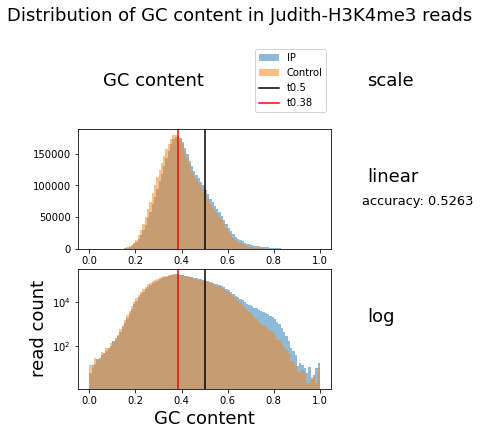

In [112]:
data='Judith-H3K4me3'
dataset_name='sharded_dataset2'
sharded = True
if sharded:
    with np.load(f'{data_dir}/{data}/{dataset_name}/test_0.npz') as f:
        x_test = f['one_hots']
    y_test = np.zeros(len(x_test), dtype=bool)
    y_test[::2] = 1
else:
    with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
        x_test = f['x_test']
        y_test = f['y_test']
gc_content = utils.GC_content(x_test)

bins = np.histogram(gc_content, bins=100, range=(0, 1))[1]
accuracy, thres = utils.classify_1D(gc_content, y_test, bins=100)
print('accuracy :', accuracy)

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'GC content'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(gc_content[y_test == 1], bins, label='IP', alpha=0.5)
    ax0.hist(gc_content[y_test == 0], bins, label='Control', alpha=0.5)
    ax0.axvline(x=0.5, color='black', label=f't0.5')
    ax0.axvline(x=thres, color='red', label=f't{round(thres, 2)}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        scale_label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        scale_label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(scale_label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("GC content", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

fig.suptitle(f'Distribution of GC content in {data} reads', fontsize=18)
plt.savefig(f'{writing_dir}/{data}/results/gc_content_classification_{dataset_name}.png', bbox_inches='tight')
plt.show()
plt.close()

## Code for selected reads in H3K27me3

In [65]:
s = 'ATCGGAAGAGCGTCGTGTAGGGAA (AATGATACGGCGA) CCACCGAGATCTACACCCTT TCGCCGTATCATTAAAAAAAAA'
mots = s.split()
print(len(mots[0]+mots[2]+mots[3]))
print(len(s)-5)

66
79


In [16]:
with open('../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2.fasta') as file:
    seqs = []
    seq = ''
    for line in file:
        if line.startswith('>'):
            if seq != '':
                seqs.append(seq)
                seq = ''
        else:
            seq += line.rstrip()
    if seq != '':
        seqs.append(seq)

In [24]:
selected = []
for seq in seqs:
    if not('ATCGGAAGAGCGTCGTGTAGG' in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' in seq):
        selected.append(seq)
print(len(selected))
# selected = []
# for seq in seqs:
#     if 'ATCGGAAGAGC' not in seq or 'GTCGTGTAGG' not in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' not in seq:
#         selected.append(seq)
# print(len(selected))

33539


In [22]:
utils.write_fasta(selected, '../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2_filtered.fasta')